In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    subplot,
    title,
    xlabel,
    ylabel,
)

# Regression part a task 1)

# Read the CSV file
titanic_data = pd.read_csv('../dataset/train.csv')

# Rename the data to a dataframe for semantics
df = titanic_data

# Take a quick look at the data again
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From our previous analysis, the fare price and the age were the only continuous variables that we identified in the dataset, and looking at the head() again, we can clearly see that this is the case again.

In our analysis, fare price is of the greatest interest (dependent variable) as it varies greatly in addition to having a tremendous amount of outliers in the dataset in the previous analysis. Attributes of interest (independent variables) in this case would be passenger class (pclass), sex, age, sipsp (siblings), parents (parch) and embarked.

To predict fare, pClass is of interest because certain classes in the titanic had certain thresholds in price. 

Age too, as typically young people would not be able to afford the vast sums of fare prices as older people would've had their whole lives to earn their fortunes, although exceptions to this might be people coming of age, who would've had their tickets bought by their relatives. 

Sex could also influence the fare prices as historically women weren't breadwinners and their tickets would then be paid for by a husband who could afford such fees. 

Sibsp and Parch are also of interest due to siblings and parent child combinations indicating family sizes and maybe larger family groups could get family discounts or maybe parents would spend less per child if they had a lot of them to keep the trip affordable.

Finally we have embarked, because perhaps we have ports such as Queentown being more busy than Cherbourg, which increases competition for tickets onboard the titanic, thereby driving up the prices from those ports.

So what is the goal of this particular regression analysis? 

We simply want to predict future fare price values based on our independent variables mentioned above and we want to find the optimal regression model that generalizes the best to new instances of data.

C:\Users\gisle\AppData\Local\Temp\ipykernel_108696\676739221.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


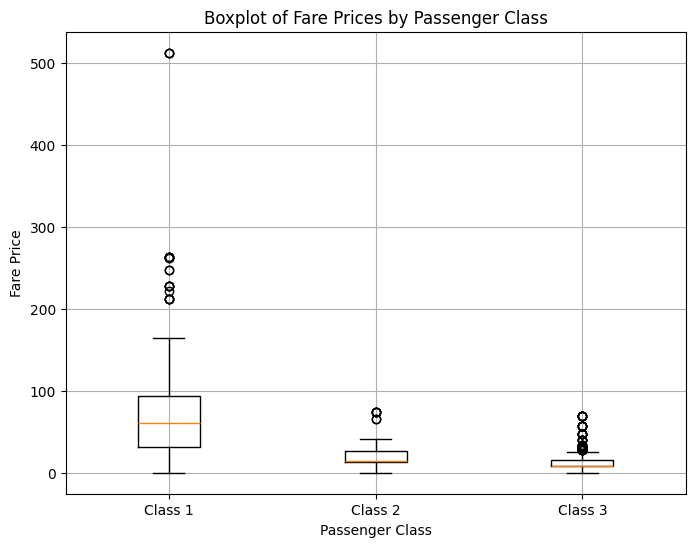

In [135]:
import matplotlib.pyplot as plt

# MIGHT DELETE THIS LATER
# Plot a boxplot of Fare grouped by Pclass because the weights weren't really making any sense in the output. 
plt.figure(figsize=(8, 6))
plt.boxplot(
    [df[df['Pclass'] == pclass]['Fare'].dropna() for pclass in sorted(df['Pclass'].unique())],
    labels=[f'Class {pclass}' for pclass in sorted(df['Pclass'].unique())]
)
plt.xlabel('Passenger Class')
plt.ylabel('Fare Price')
plt.title('Boxplot of Fare Prices by Passenger Class')
plt.grid(True)
plt.show()

In [136]:
# Count how many of the fare prices are above 200 out of total fare prices
print(f'There are {len(df[df["Fare"] > 200])} fare prices out of {len(df["Fare"])} that are above 200')

There are 20 fare prices out of 891 that are above 200


In [137]:
# Remember how there were a lot of missing values in our previous analysis, let's check for that again
missing_age = df['Age'].isna().sum()
print(f"Missing values in 'Age' column: {missing_age}")

missing_pClass = df['Pclass'].isna().sum()
print(f"Missing values in 'Pclass' column: {missing_pClass}")

missing_sex = df['Sex'].isna().sum()
print(f"Missing values in 'Sex' column: {missing_sex}")

missing_embarked = df['Embarked'].isna().sum()
print(f"Missing values in 'Embarked' column: {missing_embarked}")

missing_parch = df['Parch'].isna().sum()
print(f"Missing values in 'Parch' column: {missing_parch}")

missing_sibSp = df['SibSp'].isna().sum()
print(f"Missing values in 'SibSp' column: {missing_sibSp}")

missing_fare = df['Fare'].isna().sum()
print(f"Missing values in 'Fare' column: {missing_fare}")

# !IMPORTANT! Comment out the code below np.log1p if necessary! Log-transform 'Fare' to reduce skewness. 
# This is BY FAR the biggest factor in reducing the mean square error
# In our previous analysis, we mentioned that we may need to apply the log transformation to the 'Fare' column
# in order to reduce the skewness because remember HOW SKEWED THAT GRAPH LOOKED!

df['Fare'] = np.log1p(df['Fare'])  # Applies log(1 + Fare)

# Drop values from Fare that have values over 250
# df = df.drop(df[df['Fare'] > 200].index)

# Then df_clean has to have those rows with Fare higher than 200 removed
# df_clean = df.drop(df[df['Fare'] > 200].index)

# First, let's drop these irrelevant columns, because they don't really add much value to our analysis
df_clean = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived', 'Fare'])

df_clean.head()

Missing values in 'Age' column: 177
Missing values in 'Pclass' column: 0
Missing values in 'Sex' column: 0
Missing values in 'Embarked' column: 2
Missing values in 'Parch' column: 0
Missing values in 'SibSp' column: 0
Missing values in 'Fare' column: 0


,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,22.0,1,0,S
1,1,female,38.0,1,0,C
2,3,female,26.0,0,0,S
3,1,female,35.0,1,0,S
4,3,male,35.0,0,0,S


In [138]:
# We need to do something about the missing values, especially with age
# We can fill the missing values with the median age
df_clean['Age'] = df_clean['Age'].fillna(df['Age'].median())

# Tried removing the missing values in the 'Age' column and Embarked but the weights were still weird...
# df_clean = df_clean.dropna(subset=['Age'])

# df_clean = df_clean.dropna(subset=['Embarked'])

# We can fill out the missing values in the 'Embarked' column with the most common value
# We justify this because categorical values aren't numerical and we want them to be numerical so that we
# can perform regression with them
df_clean['Embarked'] = df_clean['Embarked'].fillna(df['Embarked'].mode()[0])

In [139]:
# Now let's feature transform the columns with string values to numerical values using one-hot encoding
# One-hot encode with dropfirst so that we dont need example male and female columns, we can just use male with 1 if true and 0 if female
df_clean = pd.get_dummies(df_clean, columns=['Sex', 'Embarked'], drop_first=True)
df_clean = pd.get_dummies(df_clean, columns=['Pclass'])

attributeNames = list(df_clean.columns)

# Now let's see how our data looks like
df_clean.head()

,Age,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,True,False,True,False,False,True
1,38.0,1,0,False,False,False,True,False,False
2,26.0,0,0,False,False,True,False,False,True
3,35.0,1,0,False,False,True,True,False,False
4,35.0,0,0,True,False,True,False,False,True


In [140]:
# Now finally, let's standardize the data
# Standardize the data using the StandardScaler import, mathematically this is fairly simple, as it involves Z scoring the data
# with Z = (X - myu) / sigma.
scaler = StandardScaler()

# Fit the scaler to the data
df_standardized = scaler.fit_transform(df_clean)

""" Got some weird scaling issues initially, I'll use this just in case I need to debug

# Check mean and standard deviation of standardized features (excluding intercept column)
means = df_standardized.mean()
std_devs = df_standardized.std()

print("Means of standardized features:\n", means)
print("Standard deviations of standardized features:\n", std_devs)

First time using this I got

Means of standardized features:
 1.0632887927573515e-17
Standard deviations of standardized features:
 1.0

 So the standardization seemed to work fine

"""
# df_standardized = pd.DataFrame(df_standardized, columns=df_clean.columns)
# df_standardized.head()


' Got some weird scaling issues initially, I\'ll use this just in case I need to debug\n\n# Check mean and standard deviation of standardized features (excluding intercept column)\nmeans = df_standardized.mean()\nstd_devs = df_standardized.std()\n\nprint("Means of standardized features:\n", means)\nprint("Standard deviations of standardized features:\n", std_devs)\n\nFirst time using this I got\n\nMeans of standardized features:\n 1.0632887927573515e-17\nStandard deviations of standardized features:\n 1.0\n\n So the standardization seemed to work fine\n\n'

In [141]:
# Regression part a task 2)

# Add offset column to allow for intercept in the model
# This is because the model is of the form y = Xw + b, where b is the intercept
# np.ones((df_standardized.shape[0], 1)) creates a column of ones with the same number of rows as the data
# np.hstack() stacks the column of ones to the left of the data and the second argument df_standardized
# tells us that this column of ones should be stacked to the left of df_standardized
X = np.hstack([np.ones((df_standardized.shape[0], 1)), df_standardized])
# Fare column is our target variable and we leave it unstandardized for now

y = df['Fare'].values 

M = X.shape[1]  # Number of features

print(f"Number of features: {M}")

# Now let's set up cross validation with 10 folds
K = 10  # Number of folds
CV = model_selection.KFold(K, shuffle=True)

Number of features: 10


In [142]:
# Like in our examples that we've looked through, we'll keep the lambda values 10^-5 to 10^8
lambdas = np.power(10.0, range(-2, 6))

# Initialize the training and test errors without regularization
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))

# Initialize the training and test errors with regularization
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))

# This w_rlr represents the weights for the regularized linear regression model
w_rlr = np.empty((M, K))

# Below arrays store the weights for each fold in the unregularized linear regression model
w_noreg = np.empty((M, K))

# Store errors across lambda values for plotting
train_err_vs_lambda = []
test_err_vs_lambda = [] 

In [143]:
# Imported the rlr_validate from the dtuimldmtools module

def rlr_validate(X, y, lambdas, cvf=10):
    """Validate regularized linear regression model using 'cvf'-fold cross validation.
    Find the optimal lambda (minimizing validation error) from 'lambdas' list.
    The loss function computed as mean squared error on validation set (MSE).
    Function returns: MSE averaged over 'cvf' folds, optimal value of lambda,
    average weight values for all lambdas, MSE train&validation errors for all lambdas.
    The cross validation splits are standardized based on the mean and standard
    deviation of the training set when estimating the regularization strength.

    Parameters:
    X       training data set
    y       vector of values
    lambdas vector of lambda values to be validated
    cvf     number of crossvalidation folds

    Returns:
    opt_val_err         validation error for optimum lambda
    opt_lambda          value of optimal lambda
    mean_w_vs_lambda    weights as function of lambda (matrix)
    train_err_vs_lambda train error as function of lambda (vector)
    test_err_vs_lambda  test error as function of lambda (vector)
    """
    CV = model_selection.KFold(cvf, shuffle=True)
    M = X.shape[1]
    w = np.empty((M, cvf, len(lambdas)))
    train_error = np.empty((cvf, len(lambdas)))
    test_error = np.empty((cvf, len(lambdas)))
    f = 0
    y = y.squeeze()
    # The first outer fold as input to this is the training set from 10% to 100%,
    # then the next time it's 0% to 10% and 20% to 100% and so on

    # This is the inner fold which we will loop over all the lambda values
    for train_index, test_index in CV.split(X, y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        """
        # We have already standardized the data, so we don't need to do it again
        # So update, apparently, there's something really strange about the values being standardized

        # Standardize the training and set set based on training set moments
        mu = np.mean(X_train[:, 1:], 0)
        sigma = np.std(X_train[:, 1:], 0)

        X_train[:, 1:] = (X_train[:, 1:] - mu) / sigma
        X_test[:, 1:] = (X_test[:, 1:] - mu) / sigma
        """

        # precompute terms as they will be used multiple times in the for loop below
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train
        # Go through each lambda in the lambdas array
        for l in range(0, len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
            # LambdaI is the regularization term remember Lambda * I in the w* = (X^T*X + lambda*I)^-1 * X^T*y
            lambdaI = lambdas[l] * np.eye(M)
            # remove bias regularization because the first column of X is the bias term and M is the number of columns in the
            # training set X, and this should not be regularized because it is not a feature
            lambdaI[0, 0] = 0
            # Below calculates the ridge regression weights for a given lambda in the fth fold and stores it in w. With this we want to
            # find the weights that minimize the loss function, which is the mean squared error whilst penalizing large weights
            # Below we get a 3d array of weights, where the first dimension holds the weights for each feature, the second dimension is the
            # for each fold f and the third dimension is for each lambda value.
            w[:, f, l] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()

            # Evaluate training and test performance
            # The mean squared error is calculated for the training and test set for each lambda value
            # We take the expected output y_train - X_train * all of our recently calculated weights from the linalg.solve() above and square it
            train_error[f, l] = np.power(y_train - X_train @ w[:, f, l].T, 2).mean(
                axis=0
            )
            test_error[f, l] = np.power(y_test - X_test @ w[:, f, l].T, 2).mean(axis=0)

        f = f + 1

    # test_error is a 2d array where the rows (this example two folds only) are the inner folds 
    # and the columns are the lambda values (this case 3) that were computed with teh mean squared error
    # if we have [0.5, 0.6, 0.8],  
    #            [0.4, 0.5, 0.7],
    # The mean() function will take the mean of the columns, so we will get [0.45, 0.55, 0.75]
    # then np.min will take the minimum value of that so we get 0.45
    opt_val_err = np.min(np.mean(test_error, axis=0))
    # Take the [0.45, 0.55, 0.75] example above, and np.argmin will return the index of the minimum value
    # Then we use that index, 0 in this case to get the lambda value that gave us the minimum mean squared error
    opt_lambda = lambdas[np.argmin(np.mean(test_error, axis=0))]
    # Using the matrix example above: The mean() function will take the mean of the columns,  [0.45, 0.55, 0.75]
    # np.mean(train_error, axis=0) computes the mean of the training errors across all folds for each lambda value.
    train_err_vs_lambda = np.mean(train_error, axis=0)
    # Same as above only for test error
    test_err_vs_lambda = np.mean(test_error, axis=0)
    # The mean of the weights across all folds for each lambda value
    mean_w_vs_lambda = np.squeeze(np.mean(w, axis=1))

    return (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    )


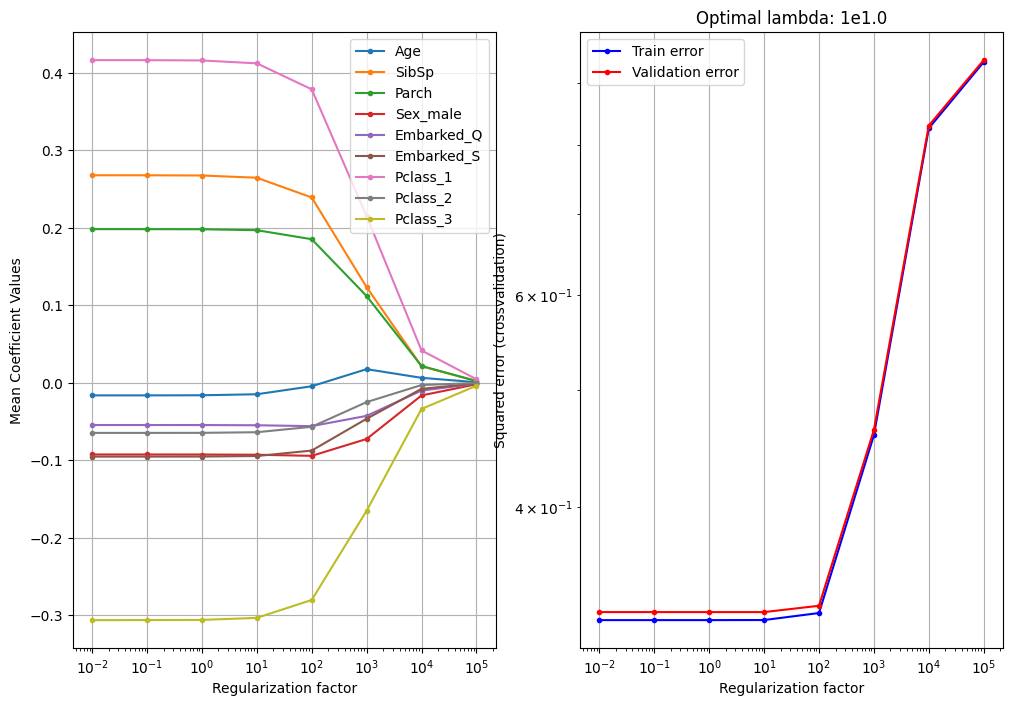

In [144]:
k = 0

# Start the cross validation by 
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    # Apply internal cross validation across multiple values of lambda 10^-5 to 10^8 to find the best
    # lambda value for the regularization effect, so for each lambda value, we estimate the model's
    # performance on the training set and the validation set
    (
        opt_val_err, # Minimum validation error across all tested values of lambda
        opt_lambda, # The lambda value that gave the minimum validation error
        mean_w_vs_lambda, # For each tested lambda, the function computed the mean of each weight, so higher values of lambda will result in smaller weights
        train_err_vs_lambda, # This array stores the training error (mean squared error) for each tested lambda
        test_err_vs_lambda, # This array stores the validation error (mean squared error) for each tested lambda
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    """
    Debug which attribute was having unusually high weights...

    # Identify the attribute with the highest mean coefficient values
    avg_coefs = np.mean(np.abs(mean_w_vs_lambda), axis=1)  # Calculate the average coefficient magnitude across lambdas
    print(f"Cross-validation fold {k+1}:")
    for i, attribute_name in enumerate(attributeNames[1:]):  # Skip the bias term
        print(f"{attribute_name}: Average coefficient magnitude across lambdas: {avg_coefs[i]}")
    print()  # Separate output for each fold for readability

    """

    # In the exercise, the dataset is standardized within the rlr_validate folds individually as well as 
    # in the outer fold here. This is not necessary, as the data is already standardized before the cross validation
    # So we'll go straight to defining the XtX and Xty terms for the training set to find 
    # the optimal w* = (X^T*X + lambda*I)^-1 * X^T*y

    # We need these two below for the optimal w* = (X^T*X + lambda*I)^-1 * X^T*y
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term

    # Find the optimal weights for the regularized linear regression model
    # Each column corresponds to the weights for each attribute in the given fold
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()

    # Compute mean squared error with regularization with optimal lambda now that we have our weights from 
    # the "optimal" lambda of the inner cross validation
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Let's compute the training and test errors without the regularization term lambda

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()

        legend(attributeNames, loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    k += 1

As we can see from the results, after countless tunings of the model with data cleaning, handling outliers, log transforms and various other techniques, we ended up with these results above. We can see that the features in the left plot starts relatively high and then it approaches 0 as the regularization factor increases, which makes sense because in the optimal w* = (X^T*X + lambda*I)^-1 * X^T*y formula, as Lambda*I approaches infinity, the weight parameters approach 0, thereby rendering the model less and less responsive the more we regularize.

The puzzling part of this model that failed to respond to changes in the model was the training and the validation rate given the regularization factor. The training and validation error is almost linear from lambda values from -3 to 2, whereby it quickly scales up almost vertically at a rapid pace the next 2 lambdas. One explanation of this is that the model without regularization itself did not overfit in the first place and that the model may already be regularized relatively well by the data itself. By the time it gets to lambda 2, the model rapidly underfits, meaning it cannot capture the details of new data very well because it lacks the flexibility to do so.

In [145]:
# Display results
print("Linear regression without regulizartion:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))

print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))


print("Weights in last fold:")
# Start from the second index to skip the bias term
for m in range(1, M):
    print("{:>15} {:>15}".format(attributeNames[m - 1], np.round(w_rlr[m, -1], 2)))


Linear regression without regulizartion:
- Training error: 0.3173390610276923
- Test error:     0.3233472115192916
Regularized linear regression:
- Training error: 0.31737884324873844
- Test error:     0.3232668217743627
Weights in last fold:
            Age           -0.01
          SibSp            0.26
          Parch             0.2
       Sex_male           -0.09
     Embarked_Q           -0.05
     Embarked_S           -0.09
       Pclass_1            0.41
       Pclass_2           -0.06
       Pclass_3            -0.3


In [146]:
"""

Linear regression without feature selection:
- Training error: 782.4508535461147
- Test error:     803.4895490275716
Regularized linear regression:
- Training error: 782.5217956573373
- Test error:     803.316904591153
Weights in last fold:
            Age           30.19
          SibSp           -1.18
          Parch            6.88
       Sex_male            7.21
     Embarked_Q           -3.34
     Embarked_S           -1.28
       Pclass_1           -2.26
       Pclass_2           17.44
       Pclass_3           -5.35

       
Linear regression without regulizartion:
- Training error: 328.5322004799806
- Test error:     337.74932410654435
Regularized linear regression:
- Training error: 328.57761882315833
- Test error:     337.73085538855145
Weights in last fold:
            Age           26.73
          SibSp           -0.61
          Parch            6.82
       Sex_male            4.06
     Embarked_Q            -3.1
     Embarked_S           -1.25
       Pclass_1           -1.67
       Pclass_2           14.15
       Pclass_3           -3.91


"""

'\n\nLinear regression without feature selection:\n- Training error: 782.4508535461147\n- Test error:     803.4895490275716\nRegularized linear regression:\n- Training error: 782.5217956573373\n- Test error:     803.316904591153\nWeights in last fold:\n            Age           30.19\n          SibSp           -1.18\n          Parch            6.88\n       Sex_male            7.21\n     Embarked_Q           -3.34\n     Embarked_S           -1.28\n       Pclass_1           -2.26\n       Pclass_2           17.44\n       Pclass_3           -5.35\n\n       \nLinear regression without regulizartion:\n- Training error: 328.5322004799806\n- Test error:     337.74932410654435\nRegularized linear regression:\n- Training error: 328.57761882315833\n- Test error:     337.73085538855145\nWeights in last fold:\n            Age           26.73\n          SibSp           -0.61\n          Parch            6.82\n       Sex_male            4.06\n     Embarked_Q            -3.1\n     Embarked_S           

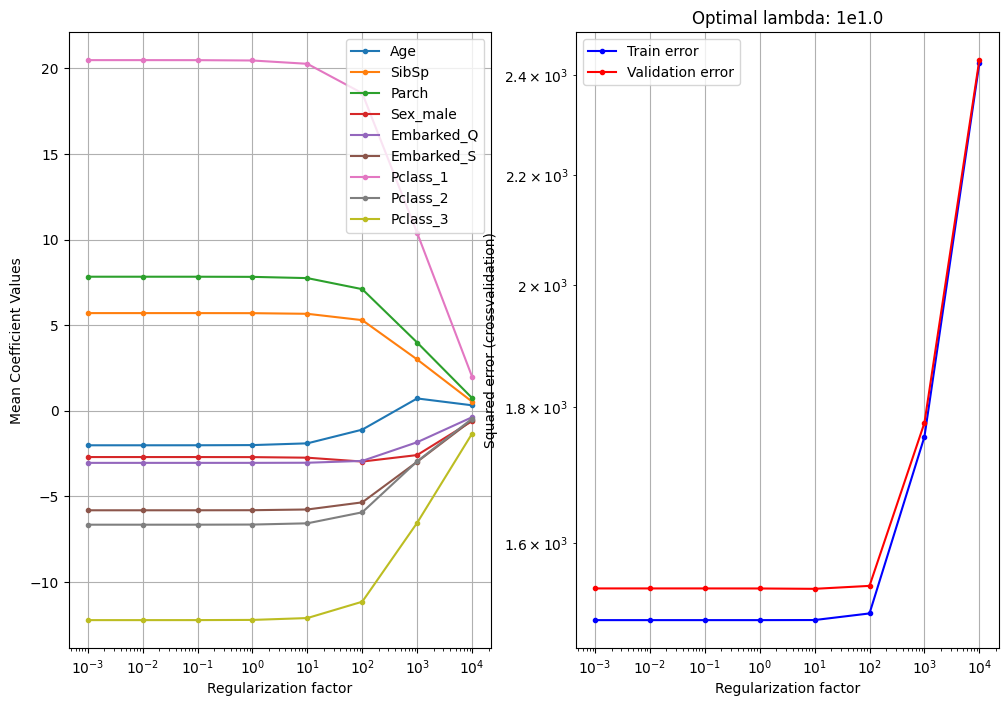

Initially without data cleaning and removing the MASSIVE outlier with that one fare price above 500, 
we got a terrible error where regularization basically did nothing.

Linear regression without feature selection:
- Training error: 1394.5347122673938
- Test error:     1442.027696235449
Regularized linear regression:
- Training error: 1394.616731799479
- Test error:     1441.5261441539164
Weights in last fold:
            Age           32.75
          SibSp           -1.91
          Parch            5.69
       Sex_male            7.74
     Embarked_Q           -2.73
     Embarked_S           -3.04
       Pclass_1           -5.77
       Pclass_2           20.29
       Pclass_3           -6.58

After removing the outlier, we got A SIGNIFICANT REDUCTION IN THE ERROR. We must data clean more, log transform might be better in this case!

Linear regression without feature selection:
- Training error: 782.4508535461147
- Test error:     803.4895490275716
Regularized linear regression:
- Training error: 782.5217956573373
- Test error:     803.316904591153
Weights in last fold:
            Age           30.19
          SibSp           -1.18
          Parch            6.88
       Sex_male            7.21
     Embarked_Q           -3.34
     Embarked_S           -1.28
       Pclass_1           -2.26
       Pclass_2           17.44
       Pclass_3           -5.35



Implications of the Log Transformation

Interpretation Changes: After transforming Fare with the natural logarithm, the model is predicting the log of Fare rather than Fare itself. When reporting results or interpreting model coefficients, you'll need to exponentiate predictions or interpret them in the log scale. For instance:
    If your model predicts a 0.5 increase in log(Fare) due to a certain factor, it means an approximate 65% increase in Fare (since e0.5≈1.65e0.5≈1.65).
    In your final report, you might want to convert predictions back to the original scale (e.g., by applying exp(predicted log(Fare)) - 1).

Loss of Additivity: Linear relationships in the original data can become multiplicative in the transformed data. For example, if Pclass has a linear impact on Fare, this impact is no longer additive in the log-transformed model. This is typically not a problem but something to be aware of when explaining the model’s behavior.

Impact on Model Performance Metrics: Since you're using log-transformed data, metrics such as Mean Squared Error (MSE) or Mean Absolute Error (MAE) will be in the log scale. For evaluation, you can convert predictions back to the original scale or use metrics that reflect the transformed scale.

Potential Issues with Zero or Negative Values: Log transformation can only be applied to positive values. Since fares are non-negative, applying log1p (log(1 + Fare)) is safe. However, if you encounter datasets with zeros or negative values in other projects, you’ll need to handle those carefully (for example, by adding a constant or filtering them out).

Choice of Base for the Logarithm: While log1p uses the natural logarithm (base ee), you might consider other bases (e.g., base 10) if there’s a specific interpretation you want, though in most cases, the natural logarithm is the standard and works well.

# Regression Part a Task 3)

Previously, we saw that the model was generally unresponsive and benefitted little from regularization and that the optimal value of $\lambda$ were $\lambda$ values from $10^{-3}$ to $10^{1}$. The weights were also relatively small.

These weights represent the optimal linear relationship between my input features and the target variable $y$ (log transformed 'Fare').

In a linear regression model, the output $y$ is computed as a weighted sum of the input features plus an intercept term. Mathematically, this can be expressed as:

$ y = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_n x_n $

where:

- $y$ is the predicted value.
- $w_0$ is the intercept or bias term.
- $w_1, w_2, \ldots, w_n$ are the coefficients (weights) of the model.
- $x_1, x_2, \ldots, x_n$ are the feature values for a given input $x$.

Each weight $w_i$ represents the contribution of the corresponding attribute $x_i$ to the prediction. For a given input $x$, we can plug in the feature values and multiply them by their respective weights, sum up all terms, and add the intercept to get the predicted $y$.

Each attribute's weight indicates how changes in that attribute impact the output $y$. Specifically:

- A positive weight means that as the value of the attribute increases, $y$ (the predicted log-Fare) also increases.
- A negative weight means that as the attribute value increases, $y$ decreases.
- The magnitude of the weight indicates the strength of the effect of that attribute on $y$.

Since the $y$ variable is log-transformed, a small increase in $y$ corresponds to a percentage increase in the original Fare value (as we applied $\log(1+\text{Fare})$).